In [1]:
import abc
import numpy as np
import matplotlib.pyplot as plt
from utils import *

## Toy Dataset with Linear Model

/work/fil_debug.py:81: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  theta = torch.solve(b[:, None], XTX)[0].squeeze(1)
THETA: tensor([7.5673, 3.8537])
coefficients:tensor([7.5673, 3.8537])
fisher info loss: tensor([2.6805, 4.1826, 3.2866, 2.8963, 2.3328, 0.9403, 0.2721, 0.8710, 1.3318,
        1.9222])


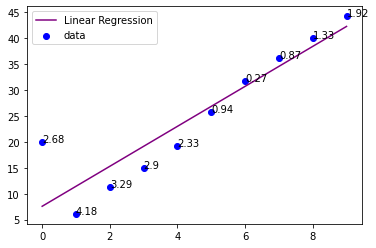

In [2]:
# Start writing code here...

# lxy debug
import torch
import numpy as np
from fil_debug import FIL_Linear_lxy, FIL_Logistic_lxy

# define dataset
X_linear = np.arange(10)
y_linear = X_linear * 5 + np.random.normal(size=len(X_linear))
y_linear[0] = 20 # extraneous outlier


data = {"features": torch.from_numpy(add_bias(X_linear)).float(), "targets": torch.from_numpy(y_linear).float()}

model = FIL_Linear_lxy()

model.train(data)


print("coefficients:{}".format(model.get_params()))

# # plot data with regression line

all_fils =  model.compute_all_fils()

print('fisher info loss:', all_fils)


fig, ax = plt.subplots()
ax.scatter(X_linear, y_linear, label="data", color="blue")
ax.plot(X_linear, model.predict(torch.from_numpy(add_bias(X_linear)).float(), regression=True), label="Linear Regression", color="purple")
plt.legend()

for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X_linear[i], y_linear[i]))
# plt.title("FIL on toy dataset with Linear Regression")
# plt.xlim(left=-0.5,right=10)
plt.savefig("figs/linear_toy.png", dpi=1200, bbox_inches="tight")
plt.show()


# print('jacobian dataset:', model.jacobian_dataset())
# model.compute_all_fils(X_linear, y_linear)

# jxy, jx1, jy1= model.jacobian_dataset()

# print(jxy, jx1, jy1)
# for i in range(10):
#     print(model.jacobian_max(X_linear[i], y_linear[i]))


In [3]:
# try some new data!

print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([1000]).float()))
print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([50]).float()))
print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([10]).float()))

tensor([339.2552])
tensor([3.0142])
tensor([11.4094])


## Toy Dataset with Logistic Model

coefficients:[ 1.3257945 -2.0051925  2.0286689]
coefficients:[ 1.3257945 -2.0051925  2.0286689]
fisher info loss: tensor([2.0362, 1.6328, 1.2868, 1.0331, 0.9182, 1.6496, 1.2015, 0.9267, 0.9746,
        1.1618, 3.4903], grad_fn=<CopyBackwards>)


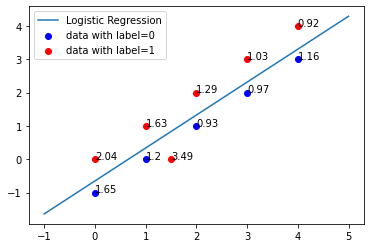

In [4]:
# define dataset
X = np.array([[x, x] for x in range(5)] + [[x, x-1] for x in range(5)])
X = np.vstack((X, np.array([[1.5, 0]]))) # Add one atypical data point 
y = np.array([1] * 5 + [0] * 5 + [1]) # labels


data = {"features": torch.from_numpy(add_bias(X)).float(), "targets": torch.from_numpy(y).float()}

model = FIL_Logistic_lxy()

model.train(data, l2=0.01)

print("coefficients:{}".format(model.get_params()))

b, w1, w2 = model.get_params()
c = -b/w2
m = -w1/w2

# plot the data and the classification with the decision boundary.
xmin, xmax = -1, 5
ymin, ymax = -1, 5
xd = np.array([xmin, xmax])
yd = m*xd+c


print("coefficients:{}".format(model.get_params()))


all_fils =  model.compute_all_fils()

print('fisher info loss:', all_fils)

fig, ax = plt.subplots()

ax.plot(xd, yd, label="Logistic Regression")
x_0 = X[y==0]
x_1 = X[y==1]
ax.scatter(x_0[:,0], x_0[:,1], label="data with label=0", color="blue")
ax.scatter(x_1[:,0], x_1[:,1], label="data with label=1", color="red")

# ax.scatter(X[:,0], X[:,1], color=[col(y_val) for y_val in y])

for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X[i][0], X[i][1]))

plt.legend()
plt.savefig("figs/logistic_toy.png", dpi=1200, bbox_inches="tight")
plt.show()



## MNIST Dataset with Linear Model

In [5]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

features, targets = mnist_trainset.data, mnist_trainset.targets

orig_img = features.clone()

features = features.float().div_(255.)
features = features.reshape(features.size(0), -1)


# only choose 0,1
num_classes = 2

mask = targets.lt(num_classes)
features = features[mask, :]
targets = targets[mask]
orig_img = orig_img[mask, :, :]

features.div_(features.norm(dim=1).max())
targets[targets == 0] = -1
targets = targets.float()

In [6]:
# num_samples = 100
# data = {"features": features[:num_samples], "targets": targets[:num_samples]}
data = {"features": features, "targets": targets}

data, mapping = pca(data, num_dims=20)

model = FIL_Linear_lxy()

model.train(data)


# print("coefficients:{}".format(model.get_params()))

# all_fils =  model.compute_all_fils()

# print('fisher info loss:', all_fils)

THETA: tensor([ 1.1464, -0.8970,  0.4447, -0.5173,  0.0891, -0.2622,  0.7167, -0.8170,
        -0.3122,  0.4717,  1.5444, -0.2781, -1.8684, -2.0651, -0.3075,  0.4101,
         0.7881,  0.2885, -0.2417,  4.0594])
/work/utils.py:65: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  _, projection = torch.symeig(covariance, eigenvectors=True)


In [7]:
all_fils =  model.compute_all_fils()

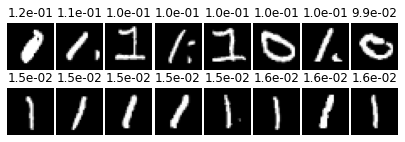

In [8]:
# Most and least leaked images:
# The results are the same as the paper's
sorted_etas = sorted(
    zip(all_fils, range(len(all_fils))), key=lambda x: x[0], reverse=True)

ims = orig_img.squeeze()
n_ims = 8
f, axarr = plt.subplots(2, n_ims, figsize=(7, 2.2))
f.subplots_adjust(wspace=0.05)
for priv in [False, True]:
    for i in range(n_ims):
        ax = axarr[int(priv), i]
        idx = -(i + 1) if priv else i
        im = sorted_etas[idx][1]
        image = ims[im, ...]
        if image.ndim == 3:
            image = image.permute(1, 2, 0)
        ax.imshow(image, cmap='gray')
        ax.axis("off")
        title = "{:.1e}".format(sorted_etas[idx][0])
        ax.set_title(title, fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.savefig("figs/linear_mnist.png", dpi=1200, bbox_inches="tight")

## MNIST Dataset with Logistic Model

In [9]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)

features, targets = mnist_trainset.data, mnist_trainset.targets

orig_img = features.clone()

features = features.float().div_(255.)
features = features.reshape(features.size(0), -1)


# only choose 0,1
num_classes = 2

mask = targets.lt(num_classes)
features = features[mask, :]
targets = targets[mask]
orig_img = orig_img[mask, :, :]

features.div_(features.norm(dim=1).max())
# targets[targets == 0] = -1 # no need to convert for lr model
targets = targets.float()


data = {"features": features, "targets": targets}

data, mapping = pca(data, num_dims=20)

In [10]:
model = FIL_Logistic_lxy()

model.train(data, l2=8e-4)

all_fils_lr =  model.compute_all_fils()

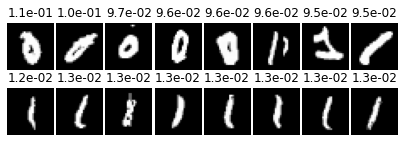

In [11]:
# Most and least leaked images:
# The results are the same as the paper's
sorted_etas = sorted(
    zip(all_fils_lr, range(len(all_fils_lr))), key=lambda x: x[0], reverse=True)

ims = orig_img.squeeze()
n_ims = 8
f, axarr = plt.subplots(2, n_ims, figsize=(7, 2.2))
f.subplots_adjust(wspace=0.05)
for priv in [False, True]:
    for i in range(n_ims):
        ax = axarr[int(priv), i]
        idx = -(i + 1) if priv else i
        im = sorted_etas[idx][1]
        image = ims[im, ...]
        if image.ndim == 3:
            image = image.permute(1, 2, 0)
        ax.imshow(image, cmap='gray')
        ax.axis("off")
        title = "{:.1e}".format(sorted_etas[idx][0])
        ax.set_title(title, fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.savefig("figs/logistic_mnist.png", dpi=1200, bbox_inches="tight")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3414c8e1-e8f2-444e-be94-05f51d01b06b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>